# Computing Heat Conduction with Python

**Lorena A. Barba**, June 2024

## Introduction

This Jupyter notebook serves as a tutorial for a Heat Transfer engineering course and is focused on solving heat-conduction problems using Python and the finite difference method. The content includes explanations of the mathematical formulation of heat-conduction problems and the implementation of 1D steady-state heat conduction solutions. 
The tutorial also covers handling unsteady-state heat conduction problems by introducing time as a variable. Additionally, students are challenged to apply their knowledge to solve real-world heat conduction problems, such as calculating temperature distribution in scenarios like a metal rod being heated at one end and cooled at the other. The notebook provides a guide for students to develop their programming skills in solving complex engineering problems related to heat conduction.

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

## 1D Steady-State Heat Conduction

We first consider a one-dimensional domain (for example, a metal rod, or a wire), with known temperatures on each end, and no heat generation. We also assume the material has constant thermal conductivity. In steady state, the question is then what is the distribution of temperature in the interior of the domain, given these conditions. 

The 1D steady state heat equation is:

$$\frac{d^2 T}{d x^2} = 0$$

To solve the 1D steady-state heat conduction equation using the finite difference method, we discretize the spatial domain into a grid of points with spacing $\Delta x$ and approximate the second derivative using a central difference scheme.

$$\frac{d^2 T}{d x^2} \approx \frac{T_{i-1}-2 T_i+T_{i+1}}{(\Delta x)^2}$$

where $T_i$ represents the temperature at grid point $i$, and 
$\Delta x$ is the spacing between grid points.

Below, we set some parameters for the problem: the fixed temperature on each boundary of the domain, the length of the domain, and the number of interior points we will use for the discretization.

In [3]:
boundary_temp = (50, 150)
length = 1
num_points = 100 # of interior points

Next, we set up an initial array for the temperature values along the 1D domain. The dimension is equal to the number of interior points selected above, plus two boundary points. We se the left and right boundary values, and compute the spatial increment.

In [4]:
temperature = np.zeros(num_points + 2) # interior points plus two boundary points
temperature[0] = boundary_temp[0]
temperature[-1] = boundary_temp[1]
dx = length / (num_points - 1)

In the next step, we set up a coefficient matrix to obtain the temperature distribution by solving a liner system of equations. First, set all the values to zero, then change the diagonal values corresponding to the finite difference formulat for the second derivative.

In [5]:
A = np.zeros((num_points, num_points))

In [6]:
A[0, 0] = 1
A[-1, -1] = 1
np.fill_diagonal(A, -2)

In [7]:
A += np.diag(np.ones(num_points-1), k=1)
A += np.diag(np.ones(num_points-1), k=-1)
print(A)

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]


In the cell above we're doing the following:

- `np.diag(np.ones(num_points-1), k=1)`: This part of the code creates a 2D array with the specified number of rows and columns, where the elements along the first diagonal above the main diagonal are set to 1, and all other elements are 0. The `k=1` parameter specifies that the diagonal to be filled is one diagonal above the main diagonal.

- `A += ...`: This part of the code adds the matrix created by `np.diag(np.ones(num_points-1), k=1)` to the existing matrix `A` element-wise. This operation modifies the matrix `A` in place by adding the values from the new matrix created.

Now we set up a right-hand-side vector for the liner system, consisting of all zero values, except for the first and last elements, corresponding to the boundary values. And next, use the NumPy built-in solver to get the temperature values in the interior points. 

In [8]:
rhs = np.zeros(num_points)
rhs[0] = -temperature[0]
rhs[-1] = -temperature[-1]

In [9]:
temperature[1:-1] = np.linalg.solve(A, rhs)

Finally, we plot the solution: a linear distribution between the boundary values.

In [10]:
x = np.linspace(0, length, num_points+2)

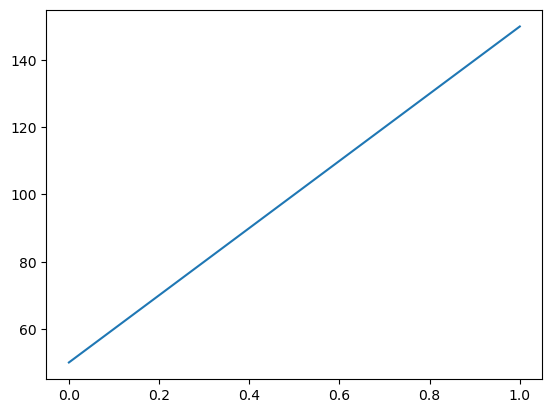

In [12]:
plt.plot(x, temperature);

We can add a heat source in the interior of the domain to make things more interesting. The equation then is: 

$$\frac{d^2 T}{d x^2} + f(x) = 0$$

where $f(x) = \dot{e}_{\text{gen}}/k$, that is the rate of heat generation per unit volume divided by the thermal conductivity.

Let's consider a constant rate of heat generation inside the domain. For example, if the domain is a long rod or wire, the heat generation could be the result of an electrical current running through it. This affects the right-hand side of the algebraic equation, where we need to subtract the constant value $f$. We can then solve the system again, and plot the resulting temperature distribution.

You should play with different values of the system conditions, and think about the physical meaning and technical consequences!

In [13]:
rhs = rhs - 0.1

In [14]:
temperature[1:-1] = np.linalg.solve(A, rhs)

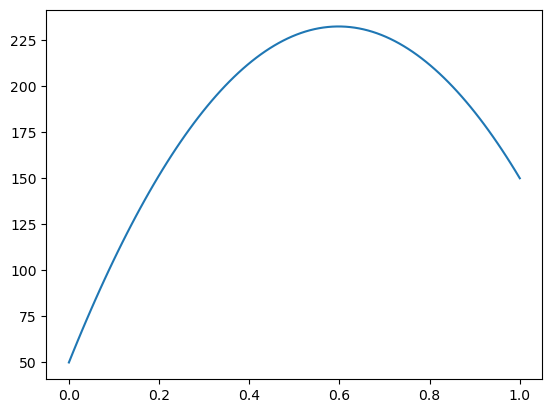

In [16]:
plt.plot(x, temperature);

## Extending to Unsteady-State Heat Conduction

In [17]:
def unsteady_state_heat_conduction(L, nx, nt, alpha, T_left, T_right, T_initial, dt, dx):
    T = np.zeros((nt, nx))
    T[0, :] = T_initial
    coeff = alpha * dt / dx**2
    
    for t in range(1, nt):
        for i in range(1, nx-1):
            T[t, i] = T[t-1, i] + coeff * (T[t-1, i+1] - 2*T[t-1, i] + T[t-1, i-1])
        
        T[t, 0] = T_left
        T[t, -1] = T_right
    
    return T

Let's break down the Python function line by line:

1. `def unsteady_state_heat_conduction(L, nx, nt, alpha, T_left, T_right, T_initial, dt, dx):`

- This line defines a function named `unsteady_state_heat_conduction` that takes in several parameters: `L` (length of the material), `nx` (number of spatial points), `nt` (number of time steps), alpha (thermal diffusivity), `T_left` (temperature at the left boundary), `T_right` (temperature at the right boundary), `T_initial` (initial temperature distribution), `dt` (time step), and `dx` (spatial step).

2. `T = np.zeros((nt, nx))`

- This line initializes a 2D NumPy array `T` of size `(nt, nx)` to store the temperature distribution over time and space. It is initialized with zeros.

3. `T[0, :] = T_initial`

- This line sets the initial temperature distribution `T_initial` along the entire spatial domain at time step 0 in the array `T`.

4. `coeff = alpha * dt / dx**2`

- This line calculates the coefficient `coeff` used in the finite difference method for solving the heat conduction equation. It is a combination of thermal diffusivity, time step, and spatial step.

5. `for t in range(1, nt):`

- This line starts a loop over the time steps, excluding the initial time step (starting from 1).

6. `for i in range(1, nx-1):`

- This line starts a loop over the spatial points, excluding the boundary points (starting from 1 and ending at `nx-2`).

7. `T[t, i] = T[t-1, i] + coeff * (T[t-1, i+1] - 2*T[t-1, i] + T[t-1, i-1])`

- This line updates the temperature at each spatial point and time step based on the finite difference method for unsteady-state heat conduction. It uses the temperature values at the previous time step to calculate the new temperature.

8. `T[t, 0] = T_left`

- This line updates the temperature at the left boundary to `T_left` at the current time step.

9. `T[t, -1] = T_right`

This line updates the temperature at the right boundary to `T_right` at the current time step.

10. `return T`

- This line returns the 2D array `T` containing the temperature distribution over time and space after the simulation.

This function calculates the temperature distribution over time and space for unsteady-state heat conduction using a finite difference method based on the provided parameters and initial conditions.

In [18]:
# Parameters
L = 1.0
nx = 41
nt = 101
alpha = 0.01
T_left = 100.0
T_right = 200.0
T_initial = 0.0
dt = 0.01
dx = L / (nx - 1)

In [19]:
temperature_distribution = unsteady_state_heat_conduction(L, nx, nt, alpha, T_left, T_right, T_initial, dt, dx)

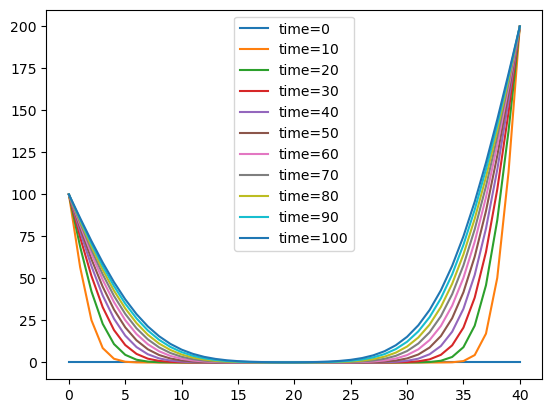

In [20]:
plt.figure()

for t in range(0, nt, 10):
    plt.plot(temperature_distribution[t], label=f"time={t}")
plt.legend()
plt.show()

It works, but the code could be improved—and this could be left for a student exercise, but I asked on the Jupyter AI interface, selecting the code for the function that computes the solution:

> In this function for the numerical solution of the two-dimensional heat equation a for-loop is used for the temperature updates on the interior points of the domain. Can we instead use vectorized array operations, with the appropriate slicing, to get a more efficient solution?


The response was:

> Yes, it is possible to leverage vectorized array operations in NumPy to achieve a more efficient solution for updating the temperature values in the two-dimensional heat conduction problem. By using array slicing and operations, we can avoid the nested for-loops and update the temperature values in a more efficient manner.
>
> Here is an updated version of the `unsteady_state_heat_conduction` function using vectorized array operations:

```python
import numpy as np

def unsteady_state_heat_conduction(L, nx, nt, alpha, T_left, T_right, T_initial, dt, dx):
    T = np.zeros((nt, nx))
    T[0, :] = T_initial
    coeff = alpha * dt / dx**2
    
    for t in range(1, nt):
        T[t, 1:-1] = T[t-1, 1:-1] + coeff * (T[t-1, 2:] - 2*T[t-1, 1:-1] + T[t-1, :-2])
        
        T[t, 0] = T_left
        T[t, -1] = T_right
    
    return T

```
> In this updated version, the inner for-loop has been replaced with a vectorized operation `T[t, 1:-1] = ...` that updates the interior points of the temperature array in a single step without the need for explicit looping over each point. This approach takes advantage of NumPy's ability to perform element-wise operations efficiently on arrays, leading to a more concise and computationally efficient solution for the unsteady heat conduction problem.

## Real-World Problem Solving

In [21]:
# Constants
L = 1.0  # Length of the rod in meters
T_left = 100.0  # Temperature at the left end in degrees Celsius
T_right = 20.0  # Temperature at the right end in degrees Celsius
k = 25.0  # Thermal conductivity of the material in W/(m*K)
rho = 7800.0  # Density of the material in kg/m^3
c = 450.0  # Specific heat capacity of the material in J/(kg*K)

In [22]:
# Grid parameters
dx = 0.01  # Spatial step size
dt = 0.1  # Time step size
nx = int(L / dx) + 1  # Number of spatial grid points
nt = 1000  # Number of time steps

In [23]:
# Initialize temperature array
T = np.zeros(nx)
T[0] = T_left
T[-1] = T_right

In [24]:
# Main loop for solving the heat conduction problem
for t in range(nt):
    T_new = np.copy(T)
    for i in range(1, nx - 1):
        T_new[i] = T[i] + k * dt / (rho * c * dx**2) * (T[i+1] - 2*T[i] + T[i-1])
    T = np.copy(T_new)

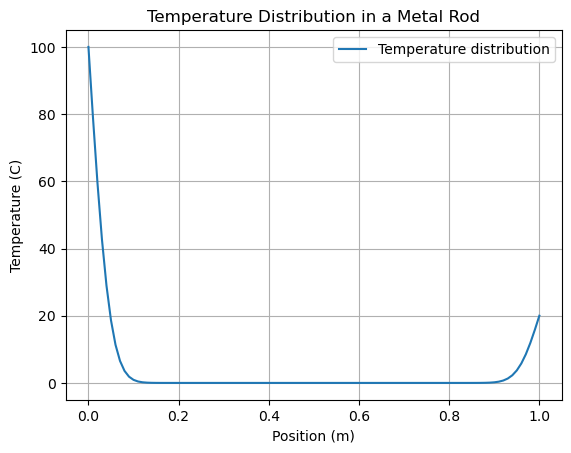

In [25]:
# Plotting the temperature distribution
x = np.linspace(0, L, nx)
plt.figure()
plt.plot(x, T, label='Temperature distribution')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (C)')
plt.title('Temperature Distribution in a Metal Rod')
plt.legend()
plt.grid()
plt.show()